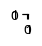

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_nested_feature_importance, plot_feature_importance, get_metrics
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.bootstrap import get_pval, plot_pval
from src.datasets import NNAlignDataset, get_NNAlign_dataloader
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

# small dim tests

In [76]:
in_dim=21*23
hidden_dim=128
n_layers=2

layers = [nn.Linear(in_dim, in_dim//2), nn.ReLU()]
for n in range(n_layers-1):
    in_dim=in_dim//2
    layers.extend([nn.Linear(in_dim, in_dim//2), nn.ReLU()])
print(layers)

[Linear(in_features=483, out_features=241, bias=True), ReLU(), Linear(in_features=241, out_features=120, bias=True), ReLU()]


# Gliph first because it's shorter

In [29]:
gliph_bulk = pd.read_excel('../data/GLIPH/GLIPH2_Mtb_TCRs_41587_2020_505_MOESM3_ESM.xlsx', sheet_name = 'bulk TCR')
gliph_sc =  pd.read_excel('../data/GLIPH/GLIPH2_Mtb_TCRs_41587_2020_505_MOESM3_ESM.xlsx', sheet_name = 'single cell TCR')
gliph_sc.drop(columns=[x for x in gliph_sc.columns if 'Unnamed' in x and not '40' in x], inplace=True)

gliph_bulk['len_beta'] = gliph_bulk['CDR3b'].apply(len)
gliph_sc['len_beta'] = gliph_sc['CDR3beta'].apply(lambda x: len(x) if x is not np.nan else np.nan)
gliph_sc['len_alpha'] = gliph_sc['CDR3alpha'].apply(lambda x: len(x) if x is not np.nan else np.nan)

In [152]:
gliph_sc

,Individual,Stim,Vbeta,Jbeta,CDR3beta,BetaConfi,BetaReads,Valpha,Jalpha,CDR3alpha,AlphaConfi,AlphaReads,2ndValpha,2ndJalpha,CDR3alpha2nd,Confi,Reads,Unnamed: 40,len_beta,len_alpha,seq_id
0,01/1013,MtbLys,TRBV28,TRBJ2-7,CASMGQIYEQYF,0.928,5434.0,TRAV9-1,TRAJ57,CALSAQGGSEKLVF,0.924,4636.0,NaN,NaN,NaN,NaN,NaN,GCCCAGGGTTTTCCCAGTCACGACGGGGTACAGTGTCTCTAGAGAG...,12.0,14.0,seq_00001
1,01/1013,MtbLys,TRBV5-1,TRBJ1-3,CASSLESVSGNTIYF,0.932,4931.0,TRAV26-1,TRAJ56,CIVRVSGAGANSKLTF,0.619,2358.0,TRAV26-2,TRAJ43,NaN,0.273,1041.0,GCCCAGGGTTTTCCCAGTCACGACCGATTCTCAGGGCGCCAGTTCT...,15.0,16.0,seq_00002
2,01/1013,MtbLys,TRBV19,TRBJ1-6,CASKRDSQAYNSPLHF,0.928,4841.0,TRAV8-3,TRAJ27,CAANTNAGKSTF,0.910,5573.0,NaN,NaN,NaN,NaN,NaN,GCCCAGGGTTTTCCCAGTCACGACGGTACAGCGTCTCTCGGGAGAA...,16.0,12.0,seq_00003
3,01/1013,MtbLys,TRBV6-1,TRBJ2-7,CASSALQAYEQYF,0.925,5296.0,TRAV17,TRAJ52,NaN,0.996,3589.0,NaN,NaN,NaN,NaN,NaN,GCCCAGGGTTTTCCCAGTCACGACTGGCTACAATGTCTCCAGATTA...,13.0,NaN,seq_00004
4,01/1013,MtbLys,TRBV20-1,TRBJ2-3,CSARSPPDTQYF,0.941,5606.0,TRAV9-1,TRAJ39,CALSDRYNNAGNMLTF,0.896,3608.0,NaN,NaN,NaN,NaN,NaN,GCCCAGGGTTTTCCCAGTCACGACGGACAAGTTTCTCATCAACCAT...,12.0,16.0,seq_00005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8250,09/0334,MtbLys,TRBV9,TRBJ1-6,CASSSSPGSNSPLHF,0.925,6794.0,mTRDV2-2,TRAJ33,CAYRSAMDSNYQLIW,0.931,5192.0,NaN,NaN,NaN,NaN,NaN,CTCCAGGGTTTTCCCAGTCACGACCTCCGCACAACAGTTCCCTGAC...,15.0,15.0,seq_08251
8251,09/0334,MtbLys,TRBV27,TRBJ1-2,CASSPGQPGGYTF,0.937,7678.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CTCCAGGGTTTTCCCAGTCACGACTACAAAGTCTCTCGAAAAGAGA...,13.0,NaN,seq_08252
8252,09/0334,MtbLys,TRBV15,TRBJ1-1,CATSRNQGANTEAFF,0.918,6276.0,TRAV12-3,TRAJ56,CASTASGANSKLTF,0.931,3495.0,NaN,NaN,NaN,NaN,NaN,CTCCAGGGTTTTCCCAGTCACGACGATAACTTCCAATCCAGGAGGC...,15.0,14.0,seq_08253
8253,09/0334,MtbLys,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,seq_08254


In [32]:
print(len(gliph_bulk))
display(gliph_bulk.head())

10501


,CDR3b,Vb,Jb,CDR3a,Va,Ja,Individual,Counts,len_beta
0,CASRDRGLSYEQYF,TRBV10-3,NaN,NaN,NaN,NaN,01/1016,1,14
1,CASRLGLAGLTQETQYF,TRBV5-1,NaN,NaN,NaN,NaN,01/1016,3,17
2,CASRPGLWGEQFF,TRBV28,NaN,NaN,NaN,NaN,01/1016,2,13
3,CASRQAGRDEQFF,TRBV6-1,NaN,NaN,NaN,NaN,01/1016,1,13
4,CASRSRGGRTYNEQFF,TRBV6-2,NaN,NaN,NaN,NaN,01/1016,2,16


In [33]:
print(len(gliph_sc))
display(gliph_sc.head())

8255


,Individual,Stim,Vbeta,Jbeta,CDR3beta,BetaConfi,BetaReads,Valpha,Jalpha,CDR3alpha,AlphaConfi,AlphaReads,2ndValpha,2ndJalpha,CDR3alpha2nd,Confi,Reads,Unnamed: 40,len_beta,len_alpha
0,01/1013,MtbLys,TRBV28,TRBJ2-7,CASMGQIYEQYF,0.928,5434.0,TRAV9-1,TRAJ57,CALSAQGGSEKLVF,0.924,4636.0,NaN,NaN,NaN,NaN,NaN,GCCCAGGGTTTTCCCAGTCACGACGGGGTACAGTGTCTCTAGAGAG...,12.0,14.0
1,01/1013,MtbLys,TRBV5-1,TRBJ1-3,CASSLESVSGNTIYF,0.932,4931.0,TRAV26-1,TRAJ56,CIVRVSGAGANSKLTF,0.619,2358.0,TRAV26-2,TRAJ43,NaN,0.273,1041.0,GCCCAGGGTTTTCCCAGTCACGACCGATTCTCAGGGCGCCAGTTCT...,15.0,16.0
2,01/1013,MtbLys,TRBV19,TRBJ1-6,CASKRDSQAYNSPLHF,0.928,4841.0,TRAV8-3,TRAJ27,CAANTNAGKSTF,0.910,5573.0,NaN,NaN,NaN,NaN,NaN,GCCCAGGGTTTTCCCAGTCACGACGGTACAGCGTCTCTCGGGAGAA...,16.0,12.0
3,01/1013,MtbLys,TRBV6-1,TRBJ2-7,CASSALQAYEQYF,0.925,5296.0,TRAV17,TRAJ52,NaN,0.996,3589.0,NaN,NaN,NaN,NaN,NaN,GCCCAGGGTTTTCCCAGTCACGACTGGCTACAATGTCTCCAGATTA...,13.0,NaN
4,01/1013,MtbLys,TRBV20-1,TRBJ2-3,CSARSPPDTQYF,0.941,5606.0,TRAV9-1,TRAJ39,CALSDRYNNAGNMLTF,0.896,3608.0,NaN,NaN,NaN,NaN,NaN,GCCCAGGGTTTTCCCAGTCACGACGGACAAGTTTCTCATCAACCAT...,12.0,16.0


In [34]:
gliph_bulk['seq_id'] = [f'seq_{i:05}' for i in range(1, len(gliph_bulk)+1)]
gliph_sc['seq_id'] = [f'seq_{i:05}' for i in range(1, len(gliph_sc)+1)]
gliph_bulk.to_csv('../data/GLIPH/230918_gliph_bulk.csv', index=False)
gliph_sc.to_csv('../data/GLIPH/230918_gliph_sc.csv', index=False)

In [72]:
gliph_merged_cdr3=pd.concat([gliph_bulk.assign(db='bulk').drop(columns=['Jb', 'CDR3a', 'Va', 'Ja']).rename(columns={'CDR3b':'CDR3beta', 'Vb':'Vbeta'}), 
           gliph_sc.assign(db='sc').drop(columns=[x for x in gliph_sc.columns if 'alpha' in x.lower()])]).dropna(subset='CDR3beta').reset_index(drop=True)
display(gliph_merged_cdr3.head()), print(len(gliph_merged_cdr3))

,CDR3beta,Vbeta,Individual,Counts,len_beta,seq_id,db,Stim,Jbeta,BetaConfi,BetaReads,Confi,Reads,Unnamed: 40
0,CASRDRGLSYEQYF,TRBV10-3,01/1016,1.0,14.0,seq_00001,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CASRLGLAGLTQETQYF,TRBV5-1,01/1016,3.0,17.0,seq_00002,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CASRPGLWGEQFF,TRBV28,01/1016,2.0,13.0,seq_00003,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CASRQAGRDEQFF,TRBV6-1,01/1016,1.0,13.0,seq_00004,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CASRSRGGRTYNEQFF,TRBV6-2,01/1016,2.0,16.0,seq_00005,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN


16663


(None, None)

In [73]:
gliph_merged_cdr3['flag'] = gliph_merged_cdr3['CDR3beta'].apply(lambda x: 'X' in x or '-' in x)
gliph_merged_cdr3.query('flag')
# Only keep the datapoints that don't have X
gliph_merged_cdr3.query('not flag').drop(columns='flag').reset_index(drop=True).to_csv('../data/GLIPH/230918_gliph_merged_cdr3beta.csv', index=False)

In [158]:
gliph_merged_cdr3 = pd.read_csv('../data/GLIPH/230918_gliph_merged_cdr3beta.csv')
len(gliph_merged_cdr3), len(gliph_merged_cdr3['CDR3beta'].unique())

(16652, 15048)

In [159]:
gliph_merged_cdr3

,CDR3beta,Vbeta,Individual,Counts,len_beta,seq_id,db,Stim,Jbeta,BetaConfi,BetaReads,Confi,Reads,Unnamed: 40
0,CASRDRGLSYEQYF,TRBV10-3,01/1016,1.0,14.0,seq_00001,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CASRLGLAGLTQETQYF,TRBV5-1,01/1016,3.0,17.0,seq_00002,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CASRPGLWGEQFF,TRBV28,01/1016,2.0,13.0,seq_00003,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CASRQAGRDEQFF,TRBV6-1,01/1016,1.0,13.0,seq_00004,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CASRSRGGRTYNEQFF,TRBV6-2,01/1016,2.0,16.0,seq_00005,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16647,CASSELEADTQYF,TRBV2,09/0334,NaN,13.0,seq_08249,sc,MtbLys,TRBJ2-3,0.934,7306.0,NaN,NaN,CTCCAGGGTTTTCCCAGTCACGACGCCTGATGGATCAAATTTCACT...
16648,CSVVEGFGSFEKRNTQYF,TRBV29-1,09/0334,NaN,18.0,seq_08250,sc,MtbLys,TRBJ2-3,0.904,5390.0,NaN,NaN,CTCCAGGGTTTTCCCAGTCACGACGTTTCCCATCAGCCGCCCAAAC...
16649,CASSSSPGSNSPLHF,TRBV9,09/0334,NaN,15.0,seq_08251,sc,MtbLys,TRBJ1-6,0.925,6794.0,NaN,NaN,CTCCAGGGTTTTCCCAGTCACGACCTCCGCACAACAGTTCCCTGAC...
16650,CASSPGQPGGYTF,TRBV27,09/0334,NaN,13.0,seq_08252,sc,MtbLys,TRBJ1-2,0.937,7678.0,NaN,NaN,CTCCAGGGTTTTCCCAGTCACGACTACAAAGTCTCTCGAAAAGAGA...


# DeepTCR

In [27]:
%ls ../data/DeepTCR/


10x_Data/             Human_Antigens/       Sidhom/
Dash_Human/           Human_HLA_Tutorial/   VDJ.tsv
Dash_Murine/          McPAS-TCR.csv         Zhang/
Glanville/            Murine_Antigens/      combine_vdj_mcpas.py
HIV/                  Rudqvist/             vdj_mcpas.csv


In [79]:
tenx = pd.read_csv('../data/DeepTCR/10x_Data/Data_Regression.csv')
tenx.head()

,alpha,beta,A0101_VTEHDTLLY_IE-1_CMV,A0201_KTWGQYWQV_gp100_Cancer,A0201_ELAGIGILTV_MART-1_Cancer,A0201_CLLWSFQTSA_Tyrosinase_Cancer,A0201_IMDQVPFSV_gp100_Cancer,A0201_SLLMWITQV_NY-ESO-1_Cancer,A0201_KVAELVHFL_MAGE-A3_Cancer,A0201_KVLEYVIKV_MAGE-A1_Cancer,...,B0702_RPHERNGFTVL_pp65_CMV,B0801_RAKFKQLL_BZLF1_EBV,B0801_ELRRKMMYM_IE-1_CMV,B0801_FLRGRAYGL_EBNA-3A_EBV,A0101_SLEGGGLGY_NC,A0101_STEGGGLAY_NC,A0201_ALIAPVHAV_NC,A2402_AYSSAGASI_NC,B0702_GPAESAAGL_NC,NR(B0801)_AAKGRGAAL_NC
0,CAAAAGEAGTYKYIF,CASSLEEGYSPLHF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CAAAANQAGTALIF,CASSFFVGGAEAFF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CAAAASDGQKLLF,CASTLPGQKQFF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CAAAAYNQGGKLIF,CATSDPAGMTGGWHGYTF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,CAAADNYGQNFVF,CAWSSGEGTDTQYF,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
tenx

,alpha,beta,A0101_VTEHDTLLY_IE-1_CMV,A0201_KTWGQYWQV_gp100_Cancer,A0201_ELAGIGILTV_MART-1_Cancer,A0201_CLLWSFQTSA_Tyrosinase_Cancer,A0201_IMDQVPFSV_gp100_Cancer,A0201_SLLMWITQV_NY-ESO-1_Cancer,A0201_KVAELVHFL_MAGE-A3_Cancer,A0201_KVLEYVIKV_MAGE-A1_Cancer,...,B0702_RPHERNGFTVL_pp65_CMV,B0801_RAKFKQLL_BZLF1_EBV,B0801_ELRRKMMYM_IE-1_CMV,B0801_FLRGRAYGL_EBNA-3A_EBV,A0101_SLEGGGLGY_NC,A0101_STEGGGLAY_NC,A0201_ALIAPVHAV_NC,A2402_AYSSAGASI_NC,B0702_GPAESAAGL_NC,NR(B0801)_AAKGRGAAL_NC
0,CAAAAGEAGTYKYIF,CASSLEEGYSPLHF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CAAAANQAGTALIF,CASSFFVGGAEAFF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CAAAASDGQKLLF,CASTLPGQKQFF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CAAAAYNQGGKLIF,CATSDPAGMTGGWHGYTF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,CAAADNYGQNFVF,CAWSSGEGTDTQYF,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57223,CSVPSLPTHPDNYGYTF,CASSASGGAPTYNEQFF,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
57224,CSVTDLQGPLNTEAFF,CASRSTGTGSTEAFF,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57225,CSVTIVDSADGELFF,CALGGTIYF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57226,CTLEIQSTESGDTALYLGSYEQYF,CASSQGQGTPTEAFF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [78]:
vdj_mcpas = pd.read_csv('../data/DeepTCR/vdj_mcpas.csv')
vdj_mcpas

,epitope,cdr3
0,LLWNGPMAV,CASSYSRTGSYEQYF
1,LLWNGPMAV,CASSQGLAYEQFF
2,LLWNGPMAV,CASSVEGPGELFF
3,LLWNGPMAV,CASSEATGASYEQYF
4,LLWNGPMAV,CASSEYVQYYGYTF
...,...,...
47292,SFHSLHLLF,CASSPPRLRDTQYF
47293,SFHSLHLLF,CISVPAARTGHRTQYF
47294,SFHSLHLLF,CASRPDRDNNYGFGF
47295,SFHSLHLLF,CASRPERDNNCF


# NetTCR data

In [81]:
%ls ../data/NetTCR

anarci_annotated_new_df.csv  new_train_df.csv
covid_controls/


In [119]:
nettcr_train = pd.read_csv('../data/NetTCR/new_train_df.csv').rename(columns={'CDR3a':'A3', 'CDR3b':'B3'}).drop(columns=['Unnamed: 0'])

In [153]:
nettcr_train.peptide.unique()

array(['ELAGIGILTV', 'RAKFKQLL', 'GLCTLVAML', 'GILGFVFTL', 'IVTDFSVIK',
       'NLVPMVATV'], dtype=object)

In [112]:
pd.set_option('display.max_columns',333)
nettcr_train.head()

,A1,A2,A3,B1,B2,B3,v_alpha,j_alpha,v_beta,j_beta,peptide,allele,origin,binder,partition,len_A1,len_A2,len_A3,len_B1,len_B2,len_B3
0,YKTSINNL,IRSNERE,CATSPHYGNNRLAF,DPISGHTAL,YFQGNSAPDKSGLPSDRFS,CASSLAPYTASTDTQYF,TRAV17*01,TRAJ7*01,TRBV7-2*01,TRBJ2-3*01,ELAGIGILTV,HLA-A*02:01,true_neg,0,5,8,7,14,9,19,17
1,YSDRGSQSF,IYSNGD,CAVSGNAGNMLTF,DPISEHNRL,YFQNEAQLEKSRLLSDRFS,CASSLAPGQGLYEQYF,TRAV12-2*01,TRAJ39*01,TRBV7-9*01,TRBJ2-7*01,RAKFKQLL,HLA-B*08:01,true_neg,0,0,9,6,13,9,19,16
2,YSVSGNPYL,YITGDNL,CAVRARSNDYKLSF,DPISEHNRL,YFQNEAQLEKSRLLSDRFS,CASSSQGGGGTDTQYF,TRAV3*01,TRAJ20*01,TRBV7-9*01,TRBJ2-3*01,RAKFKQLL,HLA-B*08:01,true_neg,0,3,9,7,14,9,19,16
3,YKTSINNL,IRSNERE,CALRRGYGNNRLAF,VQDMDHENM,FSYDVKMKEKGDIPEGYS,CASSSWDIQTNTGELFF,TRAV17*01,TRAJ7*01,TRBV28*01,TRBJ2-2*01,RAKFKQLL,HLA-B*08:01,swapped,0,1,8,7,14,9,18,17
4,YQTSGFNGL,NVLDGL,CAVRDKTDKLIF,RSLDFQATTM,TSNEGSKATYEQGVEKDKFL,CSAWGQAYGYEQYF,TRAV1-2*01,TRAJ34*01,TRBV20-1*01,TRBJ2-7*01,ELAGIGILTV,HLA-A*02:01,true_neg,0,4,9,6,12,10,20,14


In [135]:
for c in ['A1', 'A2', 'A3', 'B1', 'B2', 'B3']:
    nettcr_train[f'len_{c}'] = nettcr_train[c].apply(len)
    nettcr_train[f'flag_{c}'] = nettcr_train[c].apply(lambda z:any(['X' in x or '-' in x or '*' in x for x in z]))

lens = [f'len_{c}' for c in ['A1', 'A2', 'A3', 'B1', 'B2', 'B3']] 
flags = [f'flag_{c}' for c in ['A1', 'A2', 'A3', 'B1', 'B2', 'B3']]

In [109]:
nettcr_train[[x for x in nettcr_train.columns if 'len' in x]].describe()

,len_A1,len_A2,len_A3,len_B1,len_B2,len_B3
count,28088.000000,28088.000000,28088.000000,28088.00000,28088.000000,28088.000000
mean,9.021967,6.690188,13.598085,9.07124,18.442467,14.394617
std,0.596134,0.904765,1.960316,0.25806,0.669436,1.688912
min,8.000000,3.000000,6.000000,8.00000,17.000000,7.000000
25%,9.000000,6.000000,12.000000,9.00000,18.000000,13.000000
50%,9.000000,7.000000,14.000000,9.00000,18.000000,14.000000
75%,9.000000,7.000000,15.000000,9.00000,19.000000,15.000000
max,10.000000,8.000000,20.000000,10.00000,20.000000,20.000000


In [140]:
nettcr_train.head()

,A1,A2,A3,B1,B2,B3,v_alpha,j_alpha,v_beta,j_beta,peptide,allele,origin,binder,partition,flag,len_A1,flag_A1,len_A2,flag_A2,len_A3,flag_A3,len_B1,flag_B1,len_B2,flag_B2,len_B3,flag_B3
0,YKTSINNL,IRSNERE,CATSPHYGNNRLAF,DPISGHTAL,YFQGNSAPDKSGLPSDRFS,CASSLAPYTASTDTQYF,TRAV17*01,TRAJ7*01,TRBV7-2*01,TRBJ2-3*01,ELAGIGILTV,HLA-A*02:01,true_neg,0,5,False,8,False,7,False,14,False,9,False,19,False,17,False
1,YSDRGSQSF,IYSNGD,CAVSGNAGNMLTF,DPISEHNRL,YFQNEAQLEKSRLLSDRFS,CASSLAPGQGLYEQYF,TRAV12-2*01,TRAJ39*01,TRBV7-9*01,TRBJ2-7*01,RAKFKQLL,HLA-B*08:01,true_neg,0,0,False,9,False,6,False,13,False,9,False,19,False,16,False
2,YSVSGNPYL,YITGDNL,CAVRARSNDYKLSF,DPISEHNRL,YFQNEAQLEKSRLLSDRFS,CASSSQGGGGTDTQYF,TRAV3*01,TRAJ20*01,TRBV7-9*01,TRBJ2-3*01,RAKFKQLL,HLA-B*08:01,true_neg,0,3,False,9,False,7,False,14,False,9,False,19,False,16,False
3,YKTSINNL,IRSNERE,CALRRGYGNNRLAF,VQDMDHENM,FSYDVKMKEKGDIPEGYS,CASSSWDIQTNTGELFF,TRAV17*01,TRAJ7*01,TRBV28*01,TRBJ2-2*01,RAKFKQLL,HLA-B*08:01,swapped,0,1,False,8,False,7,False,14,False,9,False,18,False,17,False
4,YQTSGFNGL,NVLDGL,CAVRDKTDKLIF,RSLDFQATTM,TSNEGSKATYEQGVEKDKFL,CSAWGQAYGYEQYF,TRAV1-2*01,TRAJ34*01,TRBV20-1*01,TRBJ2-7*01,ELAGIGILTV,HLA-A*02:01,true_neg,0,4,False,9,False,6,False,12,False,10,False,20,False,14,False


In [115]:
nettcr_train.groupby(['peptide', 'binder']).count()

A1    A2    A3    B1    B2    B3  v_alpha  j_alpha  \
peptide    binder                                                         
ELAGIGILTV 0       3805  3805  3805  3805  3805  3805     3805     3805   
           1        316   316   316   316   316   316      316      316   
GILGFVFTL  0       6451  6451  6451  6451  6451  6451     6451     6451   
           1        969   969   969   969   969   969      969      969   
GLCTLVAML  0       3258  3258  3258  3258  3258  3258     3258     3258   
           1        173   173   173   173   173   173      173      173   
IVTDFSVIK  0       3640  3640  3640  3640  3640  3640     3640     3640   
           1        275   275   275   275   275   275      275      275   
NLVPMVATV  0       3217  3217  3217  3217  3217  3217     3217     3217   
           1        149   149   149   149   149   149      149      149   
RAKFKQLL   0       5176  5176  5176  5176  5176  5176     5176     5176   
           1        659   659   659   659   659   659      659      659   

                   v_beta  j_beta  allele  origin  partition  len_A1  len_A2  \
peptide    binder                                                              
ELAGIGILTV 0         3805    3805    3805    3805       3805    3805    3805   
           1          316     316     316     316        316     316     316   
GILGFVFTL  0         6451    6451    6451    6451       6451    6451    6451   
           1          969     969     969     969        969     969     969   
GLCTLVAML  0         3258    3258    3258    3258       3258    3258    3258   
           1          173     173     173     173        173     173     173   
IVTDFSVIK  0         3640    3640    3640    3640       3640    3640    3640   
           1          275     275     275     275        275     275     275   
NLVPMVATV  0         3217    3217    3217    3217       3217    3217    3217   
           1          149     149     149     149        149     149     149   
RAKFKQLL   0         5176    5176    5176    5176       5176    5176    5176   
           1          659     659     659     659        659     659     659   

                   len_A3  len_B1  len_B2  len_B3  
peptide    binder                                  
ELAGIGILTV 0         3805    3805    3805    3805  
           1          316     316     316     316  
GILGFVFTL  0         6451    6451    6451    6451  
           1          969     969     969     969  
GLCTLVAML  0         3258    3258    3258    3258  
           1          173     173     173     173  
IVTDFSVIK  0         3640    3640    3640    3640  
           1          275     275     275     275  
NLVPMVATV  0         3217    3217    3217    3217  
           1          149     149     149     149  
RAKFKQLL   0         5176    5176    5176    5176  
           1          659     659     659     659